In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ta
import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from Utils import utils

warnings.filterwarnings('ignore')

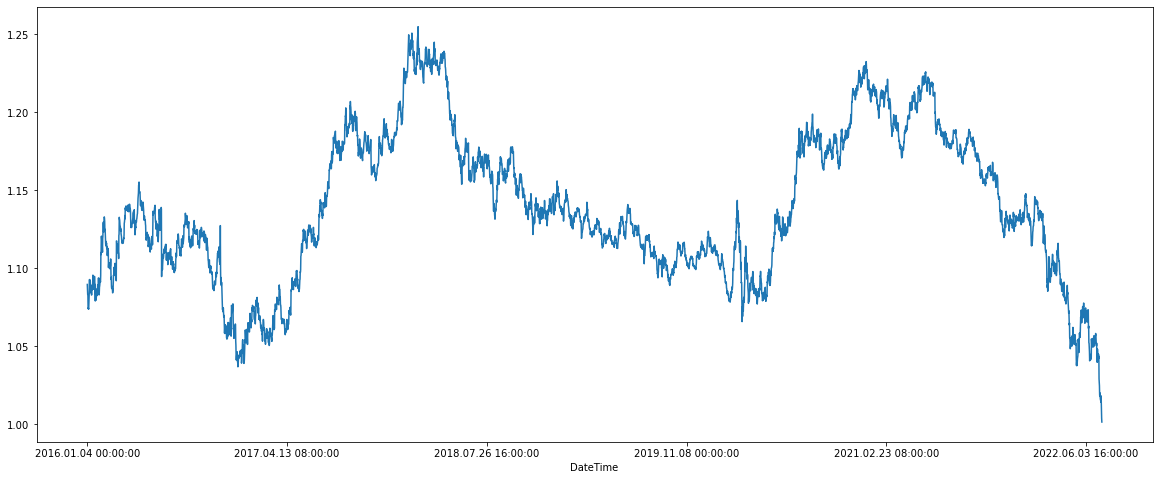

In [2]:
folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'H8', '201601040000', '202207120000'
multiplier = 100 if 'JPY' in ticker else 10000
ohlcv = pd.read_csv(folder+'/'+ticker+'_'+period+'_'+startdatetime+'_'+enddatetime+'.csv', delimiter='\t')
ohlcv = utils.prep_metatrader_data(ohlcv)
pyplot.figure(figsize=(20,8))
ohlcv['Close'].plot()
pyplot.show()

In [3]:
label = 'Median'
n = 8
X = utils.timeseries_df(ohlcv, label, n)
y = ohlcv[[label]].iloc[n:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

#regr = MLPRegressor(hidden_layer_sizes=[500, 200], 
#                    max_iter=1000, n_iter_no_change=500, verbose=False)

#regr = HistGradientBoostingRegressor(max_iter=1000, loss='absolute_error')

regr = LinearRegression()
regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

mae = mean_absolute_error(predicted, y_test)
ohlcv_test = ohlcv[ohlcv.index.isin(X_test.index)]
ach = sum(abs(ohlcv_test['High']-ohlcv_test['Low']))/len(diff)
print('Mean absolute error: ' + str(round(mae*multiplier,2)) + ' pips')
print('Average candle range: ' + str(round(ach*multiplier,2)) + ' pips')

Mean absolute error: 15.46 pips
Average candle range: 40.72 pips


In [5]:
y_pred = pd.DataFrame(index = ohlcv_test.index)
y_pred['y_pred'] = predicted
y_pred['low'], y_pred['high'] = ohlcv_test['Low'], ohlcv_test['High']
y_pred['open'], y_pred['close'] = ohlcv_test['Open'], ohlcv_test['Close'] 
y_pred

,y_pred,low,high,open,close
DateTime,,,,,
2021.03.25 00:00:00,1.182417,1.18041,1.18277,1.18122,1.18199
2021.03.25 08:00:00,1.181275,1.17910,1.18215,1.18200,1.18081
2021.03.25 16:00:00,1.180398,1.17619,1.18125,1.18079,1.17677
2021.03.26 00:00:00,1.178172,1.17677,1.17847,1.17683,1.17833
2021.03.26 08:00:00,1.177432,1.17719,1.17974,1.17831,1.17838
...,...,...,...,...,...
2022.07.08 16:00:00,1.010835,1.01342,1.01905,1.01432,1.01831
2022.07.11 00:00:00,1.018351,1.01349,1.01831,1.01696,1.01513
2022.07.11 08:00:00,1.015215,1.00748,1.01523,1.01513,1.00812


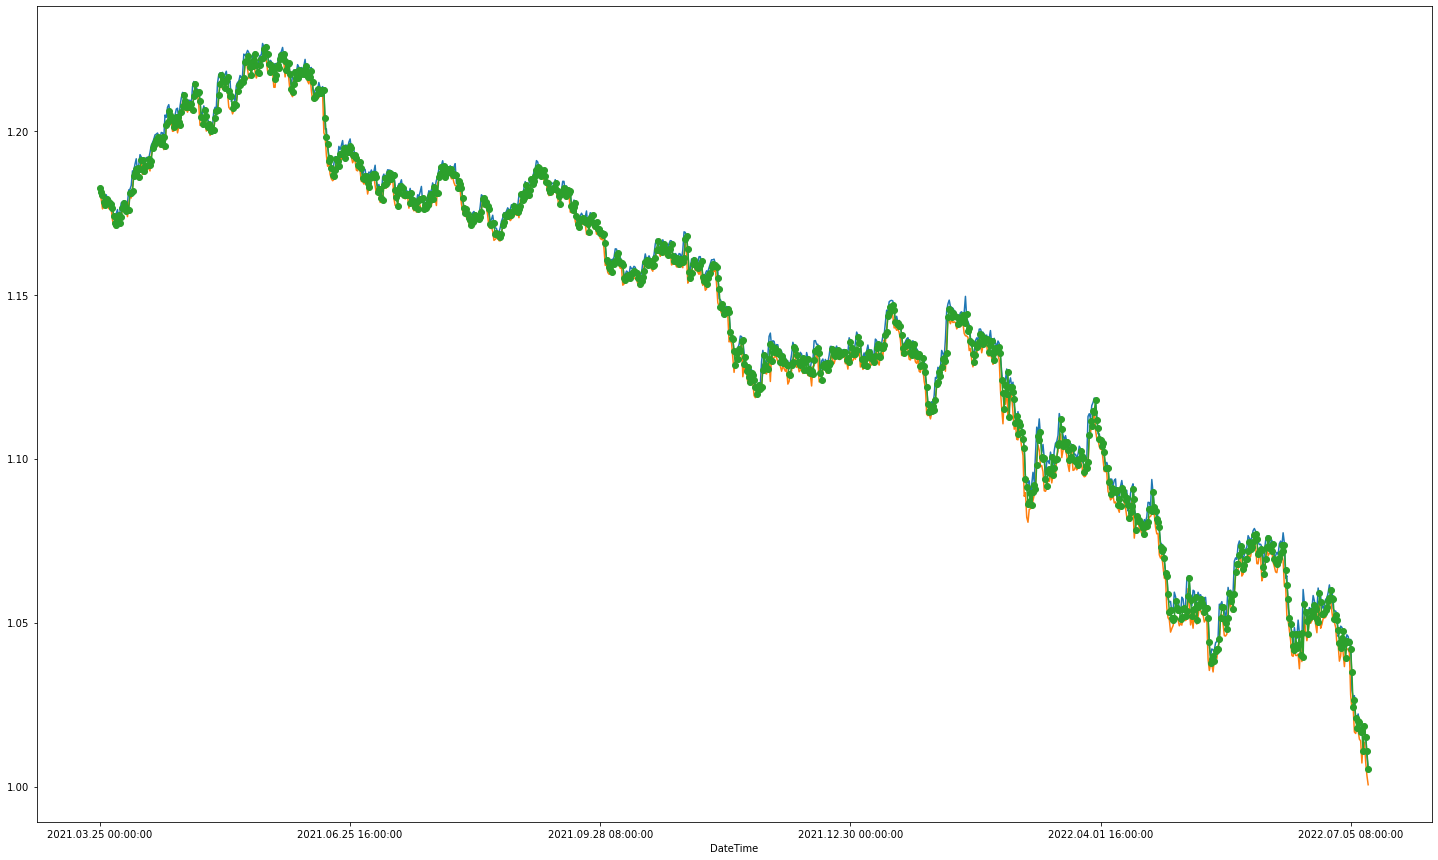

Hitrate: 68.67%
Number of candles: 1015


In [6]:
y_pred, hitrate = utils.get_hitrate(y_pred)
pyplot.figure(figsize=(25,15))
y_pred['high'].plot()
y_pred['low'].plot()
y_pred['y_pred'].plot(marker = 'o')
pyplot.show()
print('Hitrate: ' + str(round(hitrate*100,2)) + '%')
print('Number of candles: ' + str(len(y_pred)))

In [ ]:
y_pred, direction = utils.get_direction(y_pred)
y_pred, OR = utils.get_OR(y_pred)
y_pred, pips = utils.get_pips(y_pred, multiplier)
print('Direction: ' + str(round(direction*100,2)) + '%')
print('OR: ' + str(round(OR*100,2)) + '%')
print('Total pips: ' + str(pips))

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

In [ ]:
y_pred